
# Prediction with a pre-trained model 

In [1]:
from keras.models import load_model
from unet3 import *

# load json and create model 
json_file = open('model/model3.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model/pretrained_model.hdf5")
print("Loaded model from disk")

# training image dimensions
n1, n2, n3 = 128, 128, 128

Loaded model from disk


In [2]:
# set gaussian weights in the overlap bounaries
def getMask(os):
    sc = np.zeros((n1,n2,n3),dtype=np.single)
    sc = sc+1
    sp = np.zeros((os),dtype=np.single)
    sig = os/4
    sig = 0.5/(sig*sig)
    for ks in range(os):
        ds = ks-os+1
        sp[ks] = np.exp(-ds*ds*sig)
    for k1 in range(os):
        for k2 in range(n2):
            for k3 in range(n3):
                sc[k1][k2][k3]=sp[k1]
                sc[n1-k1-1][k2][k3]=sp[k1]
    for k1 in range(n1):
        for k2 in range(os):
            for k3 in range(n3):
                sc[k1][k2][k3]=sp[k2]
                sc[k1][n3-k2-1][k3]=sp[k2]
    for k1 in range(n1):
        for k2 in range(n2):
            for k3 in range(os):
                sc[k1][k2][k3]=sp[k3]
                sc[k1][k2][n3-k3-1]=sp[k3]
    return sc

def predictWithMask(gx):
    os = 12 #overlap width
    c1 = np.round((m1+os)/(n1-os)+0.5)
    c2 = np.round((m2+os)/(n2-os)+0.5)
    c3 = np.round((m3+os)/(n3-os)+0.5)
    c1 = int(c1)
    c2 = int(c2)
    c3 = int(c3)
    p1 = (n1-os)*c1+os
    p2 = (n2-os)*c2+os
    p3 = (n3-os)*c3+os
    gx = np.reshape(gx,(m1,m2,m3))
    gp = np.zeros((p1,p2,p3),dtype=np.single)
    gy = np.zeros((p1,p2,p3),dtype=np.single)
    mk = np.zeros((p1,p2,p3),dtype=np.single)
    gs = np.zeros((1,n1,n2,n3,1),dtype=np.single)
    gp[0:m1,0:m2,0:m3]=gx
    sc = getMask(os)
    for k1 in range(c1):
        for k2 in range(c2):
            for k3 in range(c3):
                b1 = k1*n1-k1*os
                e1 = b1+n1
                b2 = k2*n2-k2*os
                e2 = b2+n2
                b3 = k3*n3-k3*os
                e3 = b3+n3
                gs[0,:,:,:,0]=gp[b1:e1,b2:e2,b3:e3]
                gs = gs-np.min(gs)
                gs = gs/np.max(gs)
                gs = gs*255 
                Y = loaded_model.predict(gs,verbose=1)
                Y = np.array(Y)
                gy[b1:e1,b2:e2,b3:e3]= gy[b1:e1,b2:e2,b3:e3]+Y[0,:,:,:,0]*sc
                mk[b1:e1,b2:e2,b3:e3]= mk[b1:e1,b2:e2,b3:e3]+sc
    gy = gy/mk
    gy = gy[0:m1,0:m2,0:m3]
    return gx, gy

def stdMin(gx):
    gm = np.mean(gx)
    gs = np.std(gx)
    gx = gx-gm
    gx = gx/gs
    return gx

 
## ======================================================================

## prediction test on a field seismic image extracted from

## Canning dataset

In [3]:
import matplotlib.pyplot as plt
import segyio
%matplotlib inline
seismPath = "E:/ForVideoSegy/CanningCut.segy"
gx = segyio.tools.cube(seismPath)
print (gx.shape)
gx= gx[:, :, :256]
m1,m2, m3 = gx.shape[0], gx.shape[1], gx.shape[2]
gx = stdMin(gx)
print (gx.shape)
gx, gy = predictWithMask(gx)

(501, 501, 325)
(501, 501, 256)
1/1 [==============================] - 0s 29ms/step


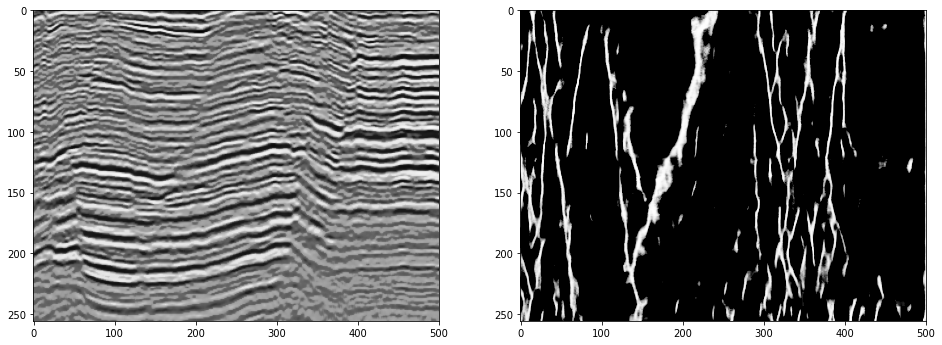

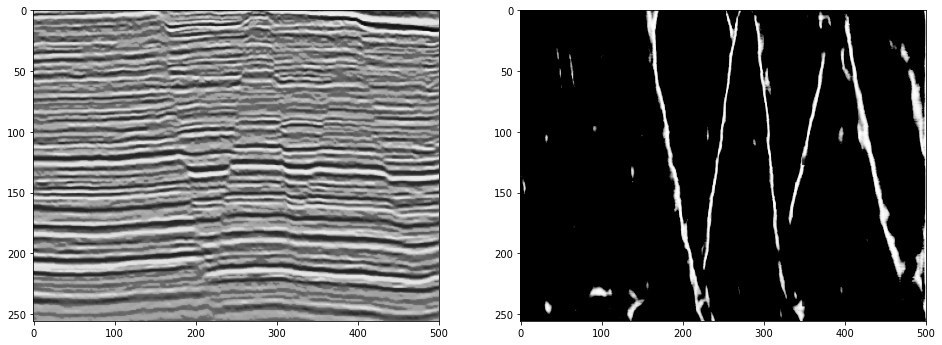

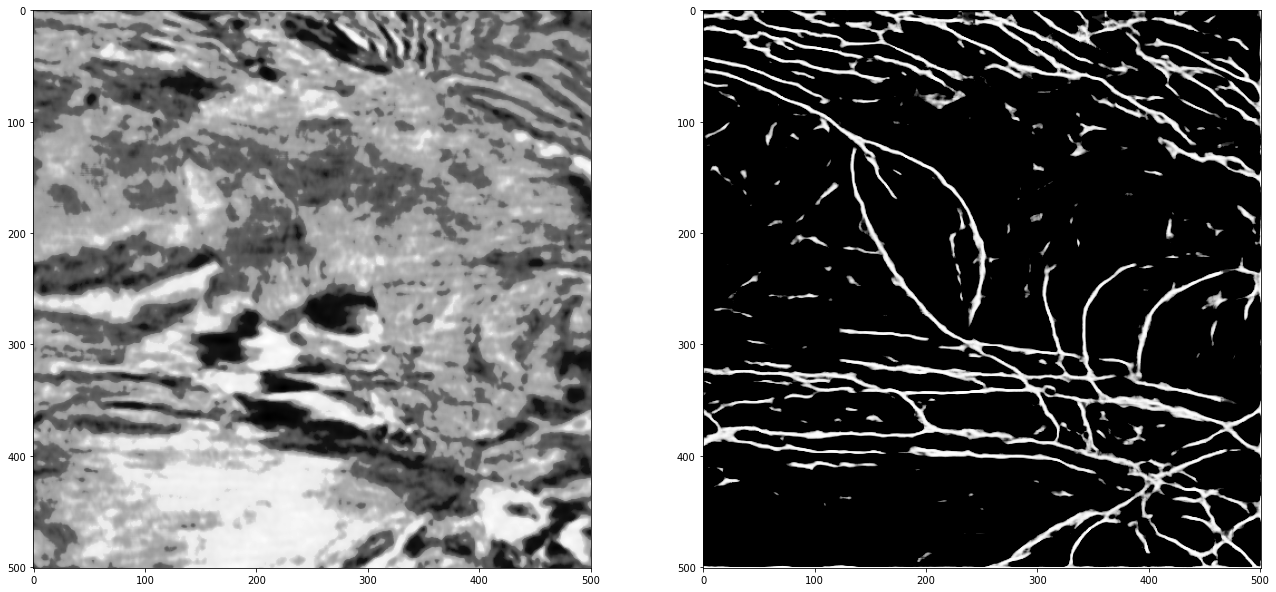

In [4]:
from matplotlib.colors import Normalize
from PIL import Image
#gx,m1,m2,m3 = np.fromfile("data/prediction/f3d/gxl.dat",dtype=np.single),512,384,128
#gy.tofile("data/prediction/f3d/"+"fp.dat",format="%4")

gx = np.reshape(gx,(m1,m2,m3))
gy = np.reshape(gy,(m1,m2,m3))

k1,k2,k3 = 150,250,110
gx1 = np.transpose(gx[k1,:,:])
gy1 = np.transpose(gy[k1,:,:])
gx2 = np.transpose(gx[:,k2,:])
gy2 = np.transpose(gy[:,k2,:])
gx3 = np.transpose(gx[:,:,k3])
gy3 = np.transpose(gy[:,:,k3])

#xline slice
fig = plt.figure(figsize=(16,16))
p1 = plt.subplot(1, 2, 1)
p1.imshow(gx1,aspect=1.5,cmap=plt.cm.gray)
p2 = plt.subplot(1,2,2)
p2.imshow(gy1,aspect=1.5,interpolation="bilinear",vmin=0.4,vmax=1.0,cmap=plt.cm.gray)

#inline slice
fig = plt.figure(figsize=(16,16))
p1 = plt.subplot(1, 2, 1)
p1.imshow(gx2,aspect=1.5,cmap=plt.cm.gray)
p2 = plt.subplot(1,2,2)
p2.imshow(gy2,aspect=1.5,interpolation="bilinear",vmin=0.4,vmax=1.0,cmap=plt.cm.gray)

#time slice
fig = plt.figure(figsize=(22,22))
p1 = plt.subplot(1, 2, 1)
p1.imshow(gx3,cmap=plt.cm.gray)
p2 = plt.subplot(1,2,2)
p2.imshow(gy3,interpolation="bilinear",vmin=0.4,vmax=1.0,cmap=plt.cm.gray)

In [5]:
import matplotlib.pyplot as plt
import segyio
%matplotlib inline
seismPath = "E:/ForVideoSegy/Delft.segy"
gx = segyio.tools.cube(seismPath)
print (gx.shape)
gx= gx[:, :, :512]
m1,m2, m3 = gx.shape[0], gx.shape[1], gx.shape[2]
gx = stdMin(gx)
print (gx.shape)

(469, 451, 951)
(469, 451, 512)


In [6]:
gx, gy = predictWithMask(gx)

1/1 [==============================] - 0s 30ms/step


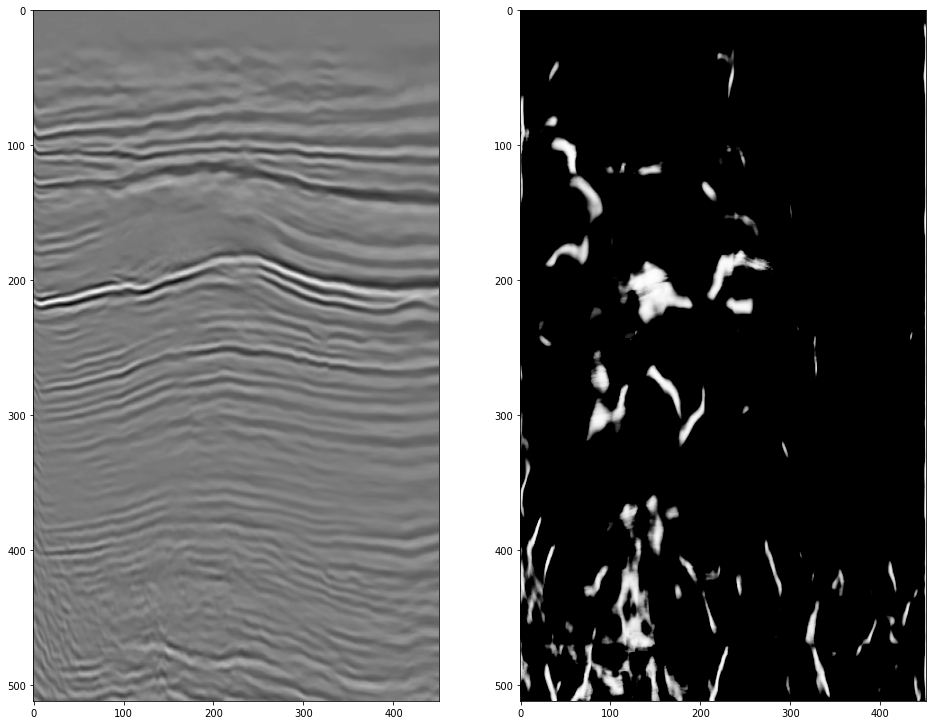

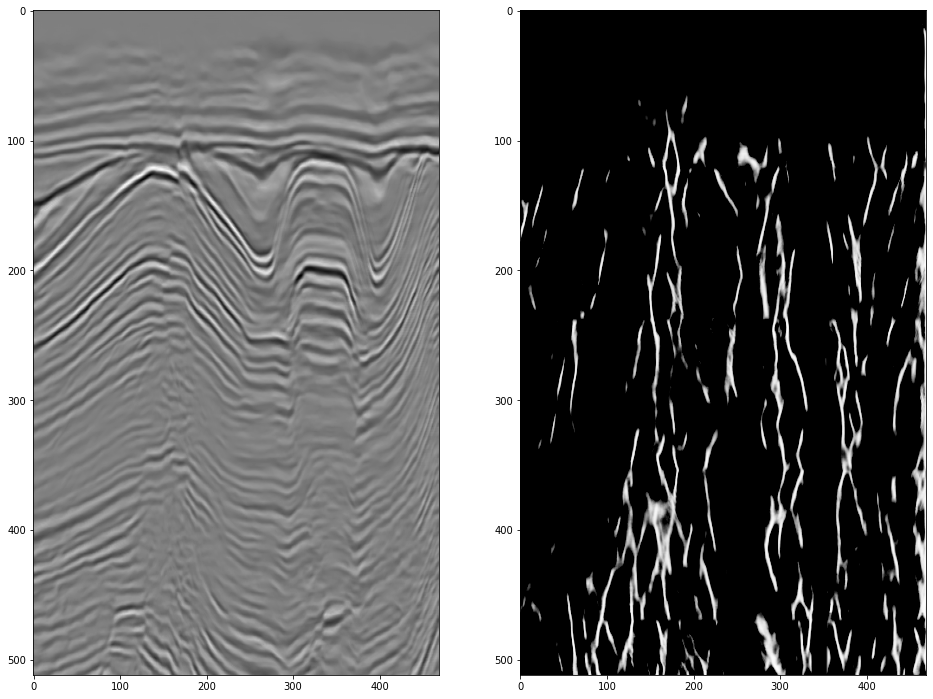

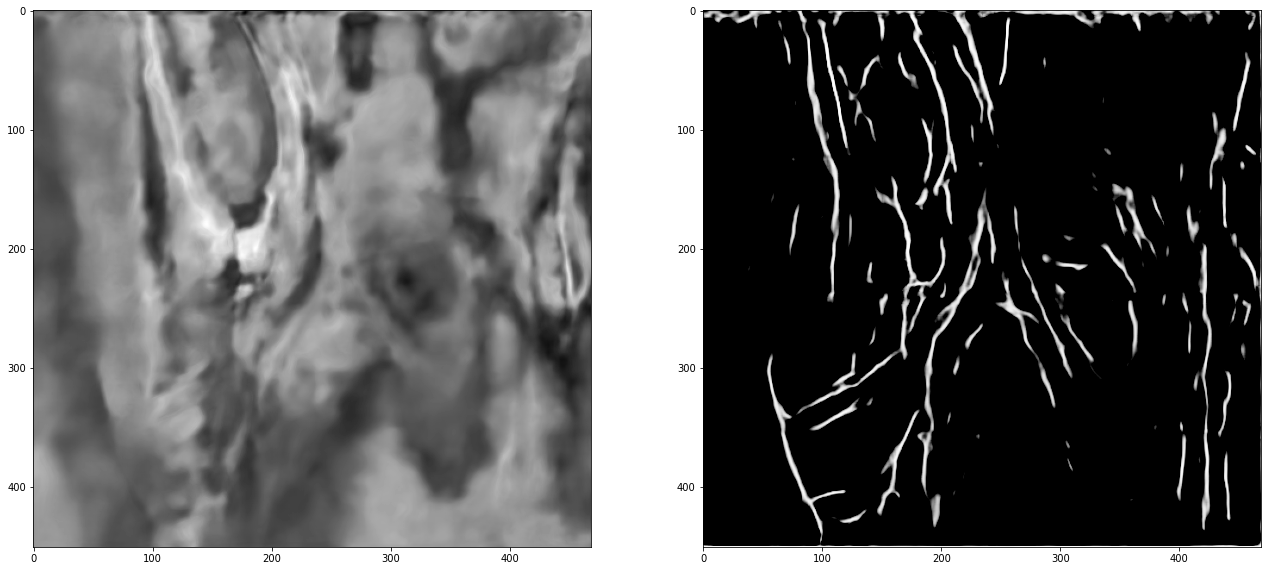

In [7]:
from matplotlib.colors import Normalize
from PIL import Image
#gx,m1,m2,m3 = np.fromfile("data/prediction/f3d/gxl.dat",dtype=np.single),512,384,128
#gy.tofile("data/prediction/f3d/"+"fp.dat",format="%4")
gx = np.reshape(gx,(m1,m2,m3))
gy = np.reshape(gy,(m1,m2,m3))

k1,k2,k3 = 250,250,110
gx1 = np.transpose(gx[k1,:,:])
gy1 = np.transpose(gy[k1,:,:])
gx2 = np.transpose(gx[:,k2,:])
gy2 = np.transpose(gy[:,k2,:])
gx3 = np.transpose(gx[:,:,k3])
gy3 = np.transpose(gy[:,:,k3])

#xline slice
fig = plt.figure(figsize=(16,16))
p1 = plt.subplot(1, 2, 1)
p1.imshow(gx1,aspect=1.5,cmap=plt.cm.gray)
p2 = plt.subplot(1,2,2)
p2.imshow(gy1,aspect=1.5,interpolation="bilinear",vmin=0.4,vmax=1.0,cmap=plt.cm.gray)

#inline slice
fig = plt.figure(figsize=(16,16))
p1 = plt.subplot(1, 2, 1)
p1.imshow(gx2,aspect=1.5,cmap=plt.cm.gray)
p2 = plt.subplot(1,2,2)
p2.imshow(gy2,aspect=1.5,interpolation="bilinear",vmin=0.4,vmax=1.0,cmap=plt.cm.gray)

#time slice
fig = plt.figure(figsize=(22,22))
p1 = plt.subplot(1, 2, 1)
p1.imshow(gx3,cmap=plt.cm.gray)
p2 = plt.subplot(1,2,2)
p2.imshow(gy3,interpolation="bilinear",vmin=0.4,vmax=1.0,cmap=plt.cm.gray)
